### Deep Learning Homework 2

Reconstruct in PyTorch the first experiment in Learning representations by back-propagating errors with learning rule in eq.8 (gradient descent without momentum) (alternative link to paper).

Try to be as close as possible to the original protocol, except for what regards the learning rule, and perhaps the random initialization method

1. Read the paper (don’t worry if you don’t understand the other experiments in detail, because our focus is on the first one)
2. Create the data, the model and everything is needed (do not use dataloaders if you don’t know yet how they work)
3. Train the model
4. Inspect the weights you obtained and check if they provide a solution to the problem

Compare the solution to the solution reported in the paper

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pylab as pl
from IPython.display import clear_output

In [2]:
# 2. Create the data, the model and everything that is needed

class MLP(nn.Module):
    """
    Implements the neural network of example 1 of the paper 
    "Learning representations by back-propagating errors"
    """
    def __init__(self):
        super().__init__()
        
        self.hidden = nn.Linear(6, 2)
        self.output = nn.Linear(2, 1)
        
    def forward(self, X):
        sigmoid = torch.sigmoid
        out = sigmoid(self.hidden(X))
        
        return sigmoid(self.output(out))
    

class Load_matrix(DataLoader):
    """
    Simple dataloader given the data matrix X and response y
    
    Parameters
    ----------
    X: 2d torch.Tensor or 2d numpy.ndarray
        The training input samples
    y: 1d torch.Tensor or 1d numpy.ndarray
        The response variable
    """
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
            
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, index):
        return self.X[index, :], self.y[index]


def is_symmetric(x):
    """
    Returns 1 if x is symmetric, 0 otherwise
    
    Parameters
    ----------
    x: 1d iterable aka list, tuple, 1d torch.tensor, 1d numpy.ndarray, ecc
        The vector to compute the symmetry
    """
    for i in range(len(x)//2):
        if x[i] != x[-(i+1)]:
            return 0
    return 1
    
def create_symmetrical_vectors(n=6):
    """
    Returns a matrix X with all the possible 0/1 combinations of n variables
    and a vector y which tells if the corresponding combination is symmmetric
    
    Parameters
    ----------
    n: int
        Number of variables to consider
        The number of elements of X goes like n*2^n so be careful
        Default is n=6
    """
    X = torch.empty((2**n, n))
    
    # Suppose I have a matrix A with all the combinations of n variables
    # I can create a matrix B=[(A, 1), (A, 0)] which will contain all the
    # combinations of n+1 variables, this is what the for loop does
    x = torch.arange((2**n))
    for i in range(n):
        m = 2**(i+1)
        X[:, i] = x%m < 2**i
    
    # Finally I create the response vector y
    y = torch.Tensor([is_symmetric(X[i, :]) for i in range(2**n)])
    
    return X, y

After 20 models we converged to 0.26772287487983704


Text(0.5, 1.0, 'Learning curve')

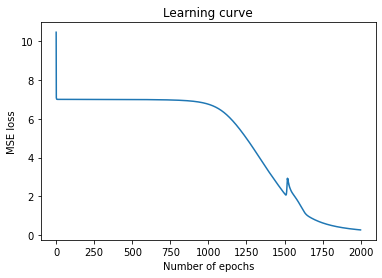

In [3]:
# 3. Train the model

def train_model(model, trainset, n_epochs, criterion, optimizer):
    """
    Trains a model and returns the loss at each epoch
    """
    losses = []
    model.train()
    for epoch in range(n_epochs):
        for data in trainset:
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs).ravel()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
    
    return losses


# Create the data
X, y = create_symmetrical_vectors(6)
dataset = Load_matrix(X, y)

# In the paper they use all the dataset at once, i.e. batch_size=64
trainset = DataLoader(dataset, batch_size=64)
# Loss function used in the paper
criterion = nn.MSELoss(reduction="sum")
# The net discussed in the paper converged in about 1200 iterations
n_epochs=2000

# Here I train models until I get a good one
models_tried = 0
current_loss = 10
while(current_loss > 1):
    # Initialize the net
    net = MLP()
    # Optimizer used in the paper with corresponding learning rate
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    models_tried += 1
    losses = train_model(net, trainset, n_epochs, criterion, optimizer)
    current_loss = losses[-1]
    print("current loss :", current_loss)

clear_output()
print(f"After {models_tried} models we converged to {losses[-1]}")

pl.plot(losses)
pl.xlabel("Number of epochs")
pl.ylabel("MSE loss")
pl.title("Learning curve")

Sometimes the model does not converge to a good minima and remains stuck, we noticed that this happens quite a lot and depends on the initial value of the parameters so we decided to train a lot of nets until a good initial set of parameters is found

In [5]:
# 4. Inspect the weights we obtained and check if they provide a solution to the problem

for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-2.3888, -9.4467, -4.7569,  4.7551,  9.4452,  2.3865],
        [ 2.3567,  9.3287,  4.6966, -4.6986, -9.3304, -2.3601]],
       requires_grad=True)
Parameter containing:
tensor([-1.8794, -1.8572], requires_grad=True)
Parameter containing:
tensor([[-11.2809, -11.3158]], requires_grad=True)
Parameter containing:
tensor([4.8864], requires_grad=True)


We see that the parameters are similar to the ones in the paper, the parameters of the two hidden units have equal modulo but opposite sign and doubles in magnitude like discussed in the paper. We now examine the accuracy and the MSE loss of our model

In [6]:
def accuracy(y_pred, y_true):
    return torch.sum(torch.round(y_pred) == y_true) / y_true.size()[0]

net.eval()
print("Accuracy:", accuracy(net(X).ravel(), y), "MSE loss:", losses[-1])

Accuracy: tensor(1.) MSE loss: 0.26772287487983704


We see that the model doesn't misclassify any data points and that the MSE is quite low considering that we are summing the MSE of 64 points and not dividing by the number of observations

### Conclusion

To get the results reported in the paper we had to retrain multiple times the same model with different values of the initial parameters and increase the number of epochs to 2000 vs 1425 of the paper, however we must say that in the paper the authors used Gradient descent with momentum while we used the classic version of gradient descent without momentum.

We also tried to train our algorithm with a binary cross entropy loss criterion (nn.BCELoss) and we noticed a much faster convergence, explored in the cell below

After 1 models we converged to 0.12354664504528046
Accuracy: tensor(1.)


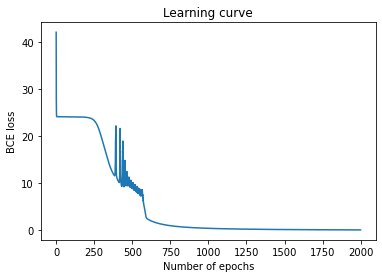

In [7]:
# BCE loss
criterion = nn.BCELoss(reduction="sum")
models_tried = 0
current_loss = 10
while(current_loss > 1):
    # Initialize the net
    net = MLP()
    # Optimizer used in the paper with corresponding learning rate
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    models_tried += 1
    losses = train_model(net, trainset, n_epochs, criterion, optimizer)
    current_loss = losses[-1]
    print("current loss :", current_loss)

clear_output()
print(f"After {models_tried} models we converged to {losses[-1]}")

pl.plot(losses)
pl.xlabel("Number of epochs")
pl.ylabel("BCE loss")
pl.title("Learning curve")

print("Accuracy:", accuracy(net(X).ravel(), y))